In [ ]:
# Compute uvgeo from SSH
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import sys
sys.path.append("/Odyssey/private/t22picar/tools")
from plot_tools import plot_uv_map 

# Gravitation parameter
constant_g = 9.81
# Coriolis parameter
constant_f0 = 2 * 7.2921e-5
# Convert degrees to meters
degtom = 111.11e3
#Mask around equator
lat_mask = 5

depth = "15m"
file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_{depth}_2010-2018.nc"

maps = xr.open_dataset(file_data)
maps

# Get longitudes and latitudes
lon = maps.lon.values
lat = maps.lat.values
lon2D, lat2D = numpy.meshgrid(lon, lat)


In [2]:
num_diff = 2  # Usual value is 2
num_centered = num_diff // 2

def compute_uvgeo(time_index):

    # 
    ssh = maps.zos.values[time_index,:]


    # Mask invalid SSH values
    ssh[abs(ssh) > 100] = numpy.nan

    # Initialize null matrices
    ugeo = numpy.full(numpy.shape(ssh), 0.)
    vgeo = numpy.full(numpy.shape(ssh), 0.)

    # Compute g/f
    goverf = constant_g / (constant_f0 * numpy.sin(numpy.deg2rad(lat2D)))

    # Compute derivatives
    dsshy = ssh[num_diff:, :] - ssh[:-num_diff, :]
    dsshx = ssh[:, num_diff:] - ssh[:, :-num_diff]
    dlonx = (
        (lon2D[:,num_diff:] - lon2D[:,:-num_diff])
        * numpy.cos(numpy.deg2rad(lat2D[:, num_centered:-num_centered]))
        * degtom
    )
    dlaty = (lat2D[num_diff:,:] - lat2D[:-num_diff,:]) * degtom

    # Compute geostrophic velocities
    ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
    vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx

    # Mask invalid values 
    #ugeo = numpy.ma.array(ugeo, mask=((abs(ugeo)>10)))
    #vgeo = numpy.ma.array(vgeo, mask=((abs(vgeo)>10)))

    #Mask close to the equator
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)<lat_mask)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<lat_mask)))

    #Mask high lat
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)>70)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<-70)))

    return(ugeo,vgeo)

In [3]:
time_index=100
# Compute first time step
(ugeo,vgeo) = compute_uvgeo(time_index) 
norm_uv = numpy.sqrt(ugeo**2 + vgeo**2)

uageo,vageo = maps.uo[time_index,:]-ugeo, maps.vo[time_index,:]-vgeo
norm_auv = numpy.sqrt(uageo**2 + vageo**2)

/tmp/ipykernel_3840911/1424388320.py:4: RuntimeWarning: invalid value encountered in sqrt
  norm_uv = numpy.sqrt(ugeo**2 + vgeo**2)


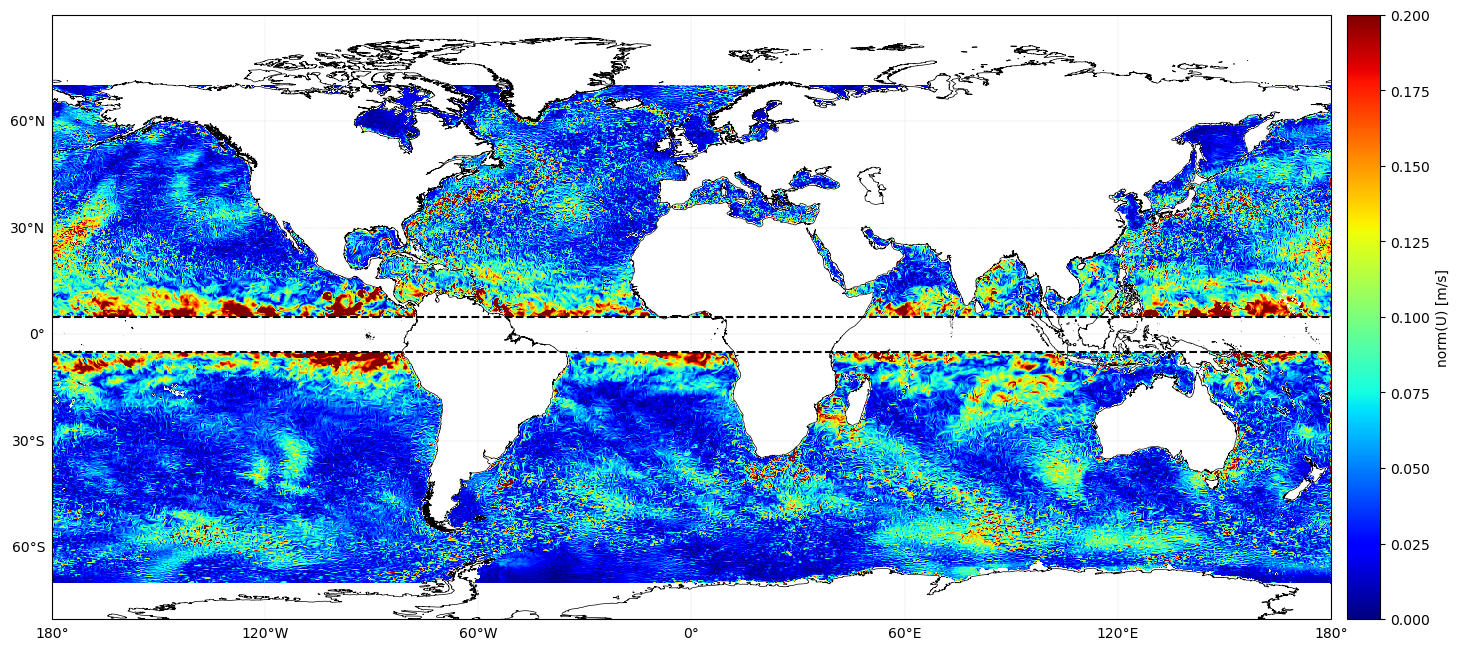

In [4]:
plot_uv_map(norm_auv,lon,lat,vmin=0,vmax=0.2,cmap=plt.cm.jet)

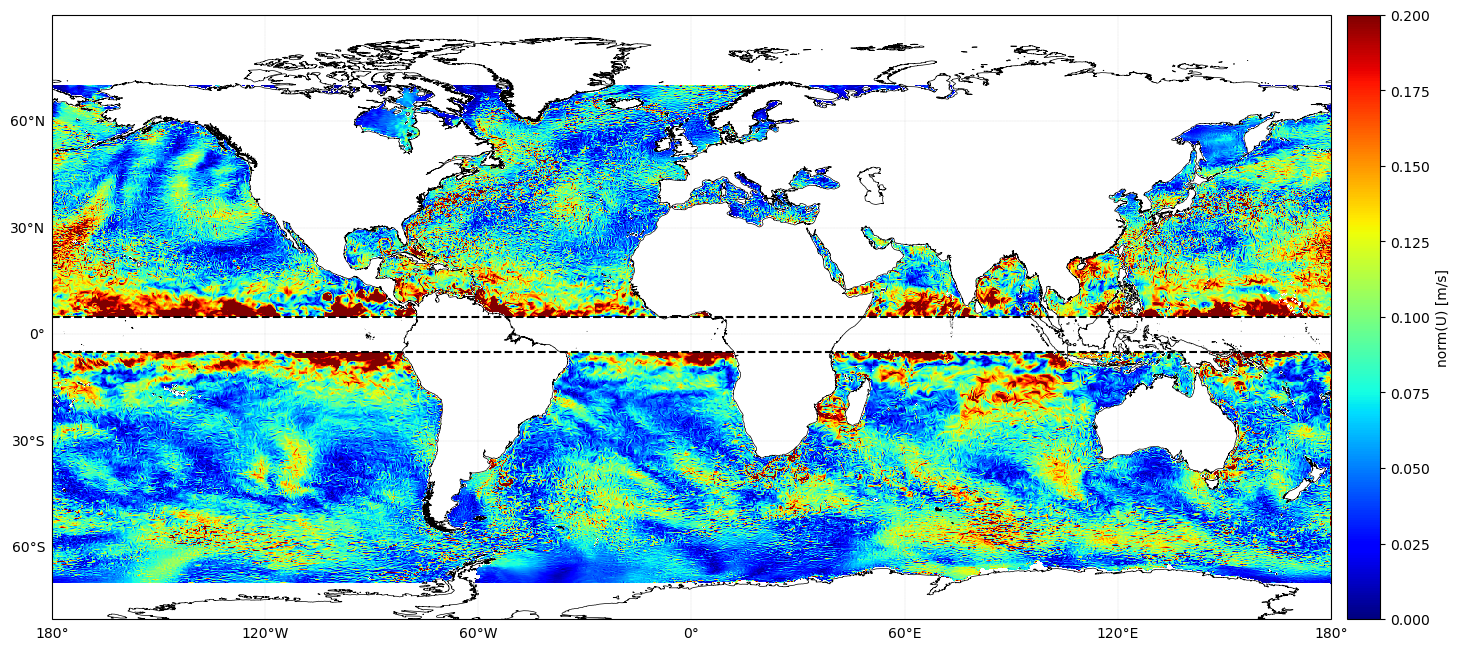

In [5]:
plot_uv_map(norm_auv,lon,lat,vmin=0,vmax=0.2,cmap=plt.cm.jet)

In [6]:
maps_ageo = maps.drop_vars("mlotst").drop_vars("zos").drop_vars("thetao")
maps_ageo

for time_index in range(3287):
    # Compute first time step
    (ugeo,vgeo) = compute_uvgeo(time_index) 

    uageo,vageo = maps.uo[time_index,:]-ugeo, maps.vo[time_index,:]-vgeo
    
    maps_ageo.uo.values[time_index] = uageo
    maps_ageo.vo.values[time_index] = vageo

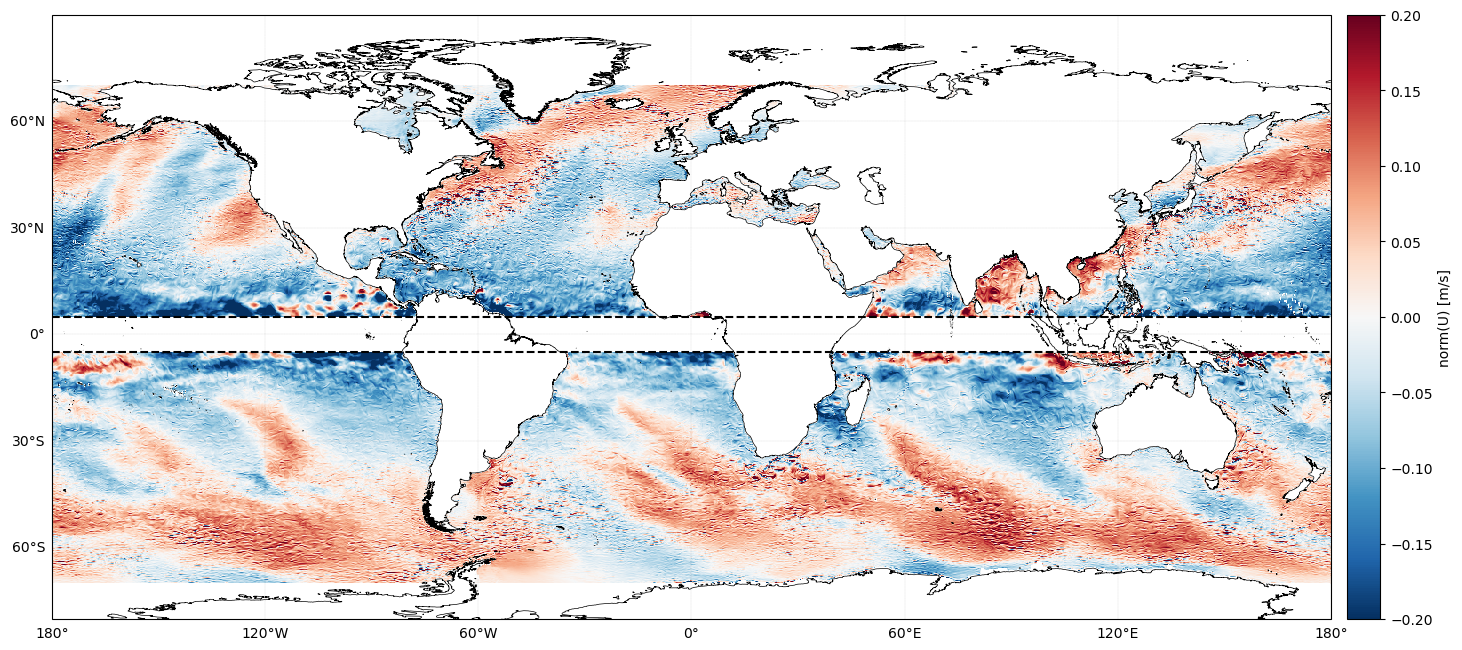

In [7]:
plot_uv_map(maps.uo[100],lon,lat,vmin=-0.2,vmax=0.2)

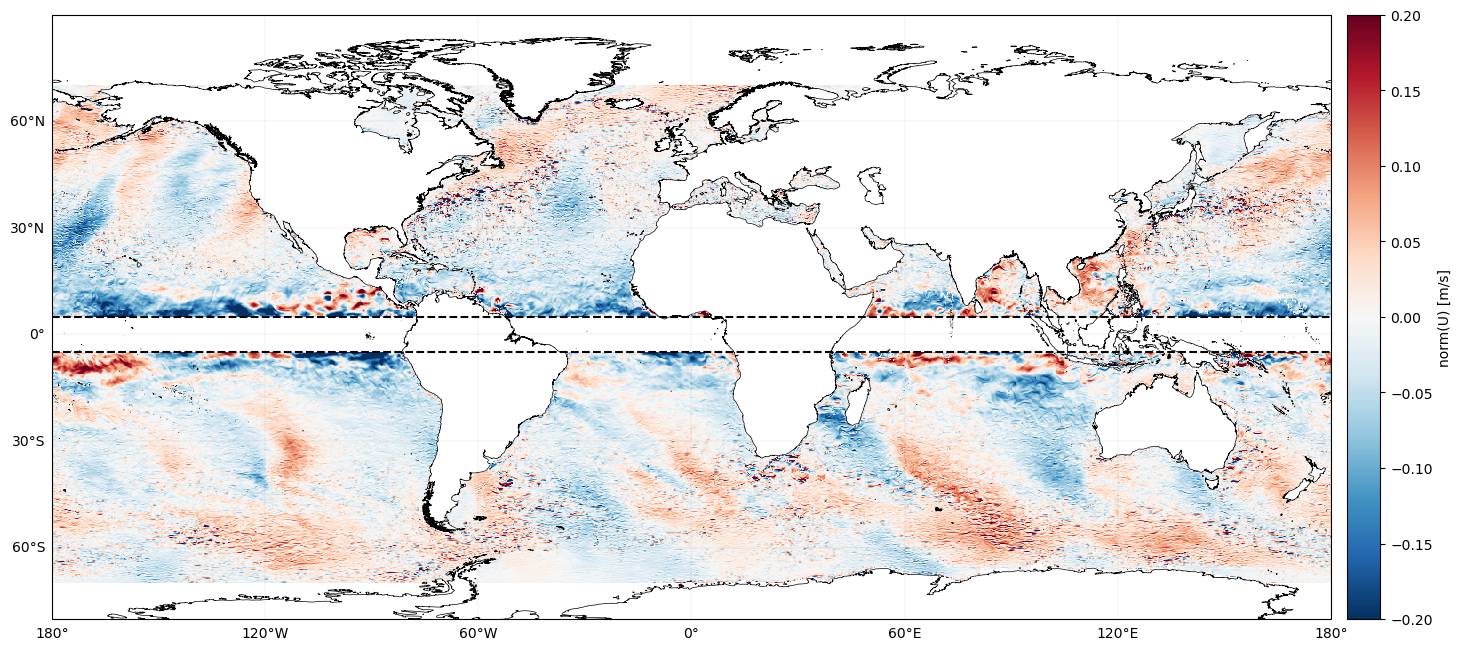

In [6]:
plot_uv_map(maps_ageo.uo[100],lon,lat,vmin=-0.2,vmax=0.2)

In [8]:
print("Saving...")
save_file=f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_uv_ageos_{depth}_2010-2018.nc"

# Sauvegarder le DataArray en fichier NetCDF
maps_ageo.to_netcdf(save_file)

Saving...
